# 1. Install Dependencies and Setup

In [ ]:
#!pip install tensorflow opencv-python matplotlib

In [ ]:
#!pip list

In [1]:
import tensorflow as tf
import os


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "d:\AnacondaDont\envs\py310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "d:\AnacondaDont\envs\py310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "d:\AnacondaDont\envs\py310\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "d:\AnacondaDont\envs\py310\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\AnacondaDont\envs\py310\li

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "d:\AnacondaDont\envs\py310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "d:\AnacondaDont\envs\py310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "d:\AnacondaDont\envs\py310\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "d:\AnacondaDont\envs\py310\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "d:\AnacondaDont\envs\py310\li

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [28]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.config.list_physical_devices('GPU'))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

[]
tf.Tensor(414.56396, shape=(), dtype=float32)


# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

C:\Users\incre\AppData\Local\Temp\ipykernel_128932\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
data_dir = 'data' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

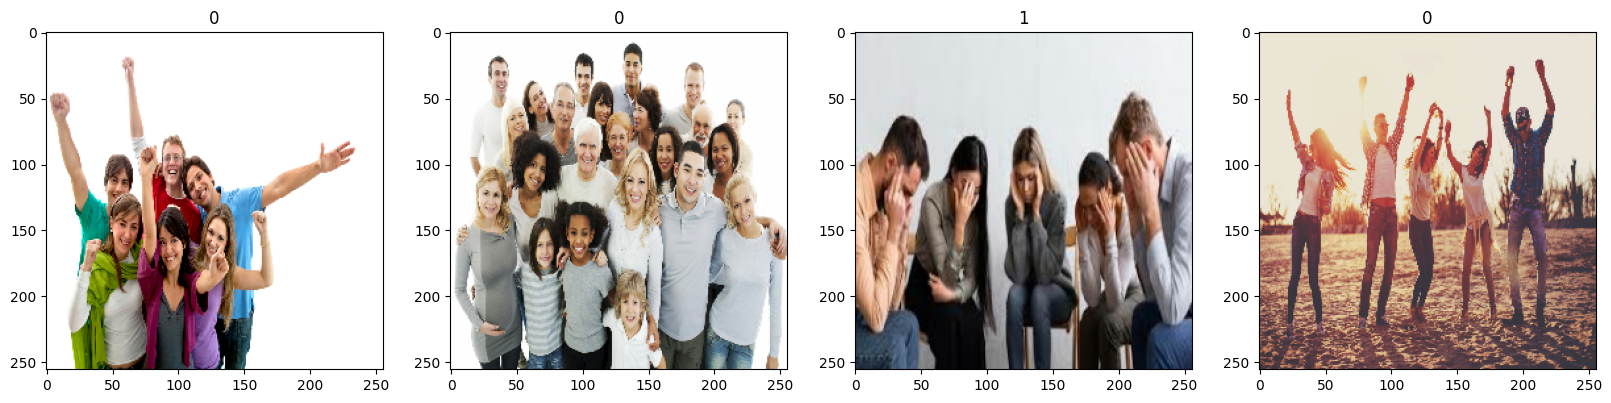

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [15]:
data.as_numpy_iterator().next()

(array([[[[0.08443245, 0.12364813, 0.1275697 ],
          [0.09534314, 0.13455883, 0.1384804 ],
          [0.07820542, 0.10957797, 0.11742111],
          ...,
          [0.11360294, 0.13321078, 0.14497548],
          [0.1168007 , 0.13640855, 0.14817326],
          [0.10698146, 0.12658931, 0.13835402]],
 
         [[0.07450981, 0.11372549, 0.11764706],
          [0.08226486, 0.12148055, 0.12540211],
          [0.07040824, 0.10178079, 0.10962393],
          ...,
          [0.09387255, 0.11348039, 0.1252451 ],
          [0.09672564, 0.11633348, 0.12809819],
          [0.08614047, 0.10574832, 0.11751302]],
 
         [[0.07732843, 0.11654412, 0.12046569],
          [0.07874157, 0.11795726, 0.12187883],
          [0.07392386, 0.10529642, 0.11313955],
          ...,
          [0.08627451, 0.10588235, 0.11764706],
          [0.09019608, 0.10980392, 0.12156863],
          [0.08198529, 0.10159314, 0.11335784]],
 
         ...,
 
         [[0.18382353, 0.18210784, 0.1625    ],
          [0.17279

# 5. Split Data

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [17]:
train_size

7

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [19]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\incre\OneDrive\Documents\Dish-Classifier-ML\imageclassification\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 866ms/step - accuracy: 0.5771 - loss: 1.4673 - val_accuracy: 0.4375 - val_loss: 0.8948
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - accuracy: 0.5061 - loss: 0.7925 - val_accuracy: 0.7812 - val_loss: 0.6515
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.7410 - loss: 0.6534 - val_accuracy: 0.8281 - val_loss: 0.6136
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 0.8000 - loss: 0.6014 - val_accuracy: 0.7812 - val_loss: 0.5488
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 532ms/step - accuracy: 0.7937 - loss: 0.5316 - val_accuracy: 0.8750 - val_loss: 0.4025
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - accuracy: 0.8357 - loss: 0.4224 - val_accuracy: 0.9062 - val_loss: 0.2843
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - accuracy: 0.8939 - loss: 0.3426 - val_accuracy: 0.8594 - val_loss: 0.2843
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 573ms/step - accuracy: 0.9043 - loss: 0.2693 - val_accuracy: 0.8750 - val_loss:

# 8. Plot Performance

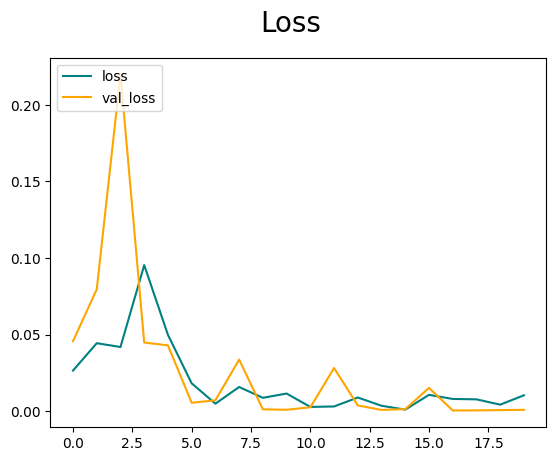

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

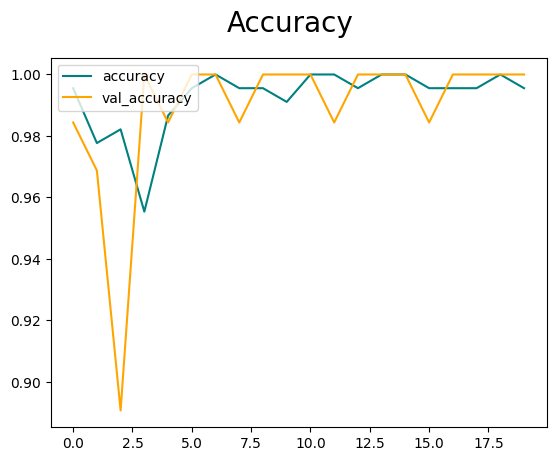

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 27ms/step


In [41]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [42]:
import cv2

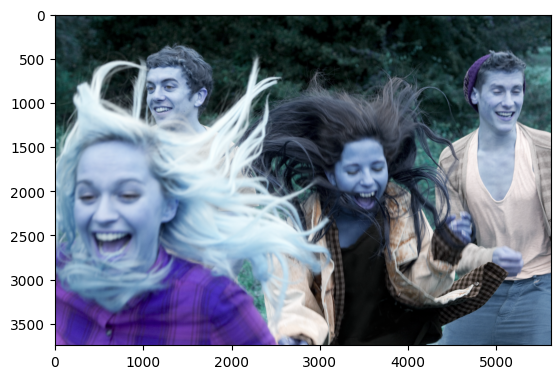

In [64]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

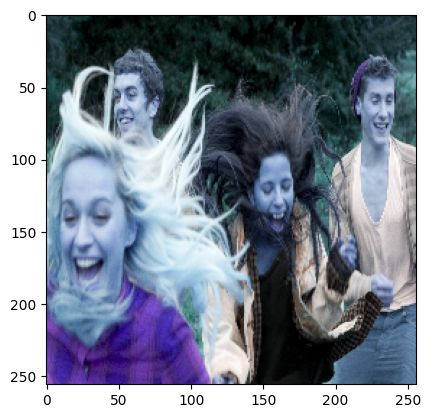

In [65]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [66]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 20ms/step


In [67]:
yhat

array([[0.99204856]], dtype=float32)

In [68]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [69]:
from tensorflow.keras.models import load_model

In [70]:
model.save(os.path.join('models','imageclassifierNEWv1.h5'))

In [72]:
new_model = load_model(os.path.join('models','imageclassifierNEWv1.h5'))

In [73]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 65ms/step


array([[0.99204856]], dtype=float32)